In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(conn, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=conn)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date)\
    .order_by(Measurement.date.desc()).first()[0]
print(most_recent)

2017-08-23


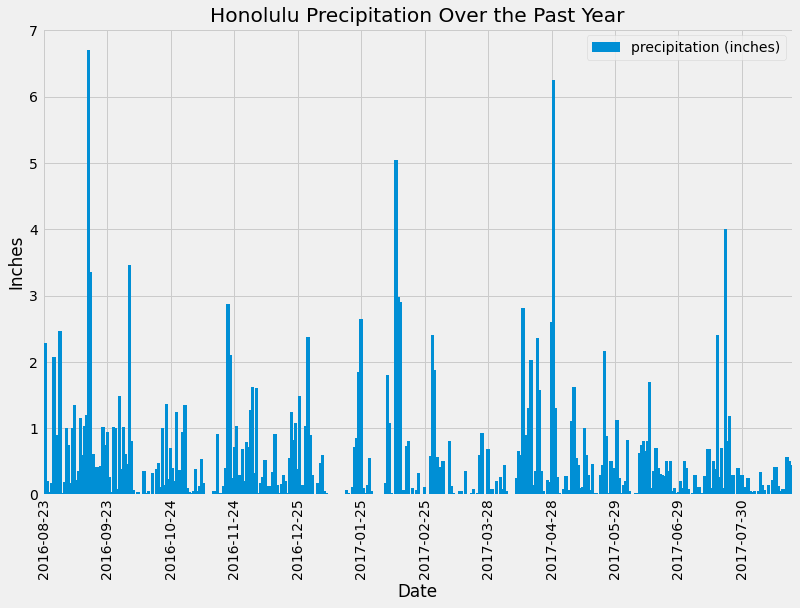

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
end_date = dt.datetime.fromisoformat(most_recent).date()
twelve_months_prior = end_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= twelve_months_prior)\
    .filter(Measurement.date <= end_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=["date", "precipitation (inches)"])
df = df.set_index("date")

# Sort the dataframe by date
sum_df = df.groupby("date").max()

# Use Pandas Plotting with Matplotlib to plot the data
sum_df.plot.bar(
    rot="vertical",
    grid=True,
    title="Honolulu Precipitation Over the Past Year",
    xlabel="Date",
    ylabel="Inches",
    legend=True,
    align="center",
    figsize=(12,8),
    width=1.6
)
plt.locator_params(nbins=12)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_df.describe()

,precipitation (inches)
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(func.distinct(Measurement.station)).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for row in active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
min_temp = session.query(func.min(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)[0][0]
avg_temp = session.query(func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)[0][0]
max_temp = session.query(func.max(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)[0][0]

print(f"{most_active_station} temperature data (F):")
print("-"*30)
print(f"Minimum temperature: {min_temp}")
print(f"Maximum temperature: {max_temp}")
print(f"Average temperature: {round(avg_temp, 1)}")

USC00519281 temperature data (F):
------------------------------
Minimum temperature: 54.0
Maximum temperature: 85.0
Average temperature: 71.7


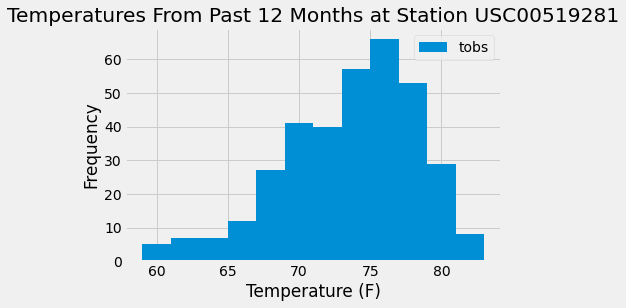

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= twelve_months_prior)\
    .filter(Measurement.date <= end_date)

x = [row[0] for row in temps]

plt.hist(x, bins=12, label="tobs")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperatures From Past 12 Months at Station {most_active_station}")
plt.legend()
plt.show()

# Close session

In [16]:
# Close Session
session.close()